## 視聴率予測

### 前処理

In [24]:
#学習データは2018-2020
#テストデータは2021とする
import pandas as pd
tbs_golden_2018 = pd.read_csv("tbs_embeddings_SimCSE_2018.csv")
tbs_golden_2019 = pd.read_csv("tbs_embeddings_SimCSE_2019.csv")
tbs_golden_2020 = pd.read_csv("tbs_embeddings_SimCSE_2020.csv")
tbs_golden_2021 = pd.read_csv("tbs_embeddings_SimCSE_2021.csv")

tbs_golden_all = pd.concat([tbs_golden_2018, tbs_golden_2019, tbs_golden_2020, tbs_golden_2021], ignore_index=True)


In [25]:
# 平均じゃなくする
import ast
import re
import numpy as np

# 文字列をリストに変換する関数
def parse_embedding(embedding_str):
    # スペースで区切られた数値を適切にカンマで区切り、リスト形式に変換
    # リストのカンマの位置を修正
    corrected_str = re.sub(r'(\d)(-)', r'\1, \2', embedding_str)  # 数値とマイナス記号の間にカンマを追加
    corrected_str = corrected_str.replace(' ', ',').replace(',,', ',')  # 連続するカンマを修正
    corrected_str = corrected_str.replace('[,', '[').replace(',]', ']')  # リストの先頭と末尾のカンマを修正
        
    # リストを評価
    embedding_list = ast.literal_eval(corrected_str)
    return np.array(embedding_list)

tbs_golden_all['embedding'] = tbs_golden_all['embedding'].apply(parse_embedding)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X = tbs_golden_all["embedding"].tolist()
y = tbs_golden_all["setai"]
y = np.array(y)

# 標準化
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [27]:
print(len(X))

3227


### 学習

#### 線形回帰

In [28]:
# 線形回帰
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [29]:
from sklearn.metrics import mean_squared_error

# テストデータで予測を実行
y_pred = lr.predict(X_test)

# 平均二乗誤差 (MSE) を計算
mse = mean_squared_error(y_test, y_pred)

# MSEを表示
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 4.505


In [30]:
# 架空の番組内容
#世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。
print("番組内容を記述してください")
list_input_text = [input()]
print(list_input_text)

番組内容を記述してください
世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。
['世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。']


In [31]:
import re
import neologdn

# '番組内容' と '出演者' 以降を削除
def clean_description(text):
    # '出演者' 以降を削除
    text = re.split(r'-- 出演者 --', text)[0]
    # '番組内容' という文字列を削除
    text = re.sub(r'番組内容\s*', '', text)
    text = neologdn.normalize(text)
    
    return text

# 各行に対してクリーンアップ処理を実行
text = clean_description(list_input_text[0])
print(text)


世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。


In [32]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("cl-nagoya/sup-simcse-ja-base")

embedding = embedding_model.encode(text)

embedding = embedding.reshape(1,-1)
pred = lr.predict(embedding)

print("予想の世帯視聴率",pred)

予想の世帯視聴率 [13.55365136]


#### 線形回帰, リッジ回帰, ラッソ回帰, エラスティックネット, 決定木, ランダムフォレスト, Adaboost 比較

In [33]:
from sklearn.metrics import mean_squared_error

# モデル作成と検証
result_df = pd.DataFrame()
for name, reg in tqdm(zip(reg_names, regressors), total=len(reg_names), desc="Regression models"):
    print(name)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    
    # 各種スコアの計算
    mae = mean_absolute_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    r2 = reg.score(X_test, y_test)  # 決定係数の計算

    # データフレームに結果を追加
    tmp_df = pd.DataFrame(data=[[name, mae, rmse, r2]], columns=['name', 'MAE', 'RMSE', 'R²'])
    result_df = pd.concat([result_df, tmp_df], ignore_index=True)

# 結果の表示
print(result_df)


Regression models:   0%|          | 0/7 [00:00<?, ?it/s]

Linear


Regression models:  29%|██▊       | 2/7 [00:00<00:01,  4.14it/s]

Ridge
Lasso


Regression models:  43%|████▎     | 3/7 [00:00<00:00,  5.33it/s]

ElasticNet
DecisionTree


Regression models:  71%|███████▏  | 5/7 [00:02<00:01,  1.38it/s]

RandomForest


Regression models:  86%|████████▌ | 6/7 [02:10<00:37, 37.29s/it]

AdaBoost


Regression models: 100%|██████████| 7/7 [02:24<00:00, 20.61s/it]

           name       MAE      RMSE        R²
0        Linear  1.583243  2.122419  0.427913
1         Ridge  1.439151  1.935388  0.524297
2         Lasso  1.654843  2.318254  0.317470
3    ElasticNet  1.885644  2.681163  0.087051
4  DecisionTree  2.110634  2.914580 -0.078827
5  RandomForest  1.459010  2.061841  0.460104
6      AdaBoost  1.563868  2.111262  0.433912


In [9]:
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.linear_model import Ridge # リッジ回帰
from sklearn.linear_model import Lasso # ラッソ回帰 
from sklearn.linear_model import ElasticNet # エラスティックネット，リッジ回帰とLasso回帰の折衷案
from sklearn.tree import DecisionTreeRegressor # 決定木
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト
from sklearn.ensemble import AdaBoostRegressor # ブースティング（Adaboost）

from sklearn.metrics import mean_absolute_error

from tqdm import tqdm

reg_names = ['Linear','Ridge','Lasso','ElasticNet','DecisionTree','RandomForest', 'AdaBoost']

regressors =[
    LinearRegression(),
    Ridge(alpha=10),
    Lasso(alpha=0.1),
    ElasticNet(alpha=1.0, l1_ratio=0.5),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor()
]

# モデル作成と検証
result_df = pd.DataFrame()
for name, reg in tqdm(zip(reg_names, regressors), total = len(reg_names), desc = "Regressoin models"):
    print(name)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    mae  = mean_absolute_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))

    tmp_df = pd.DataFrame(data=[[name,mae,rmse]],columns=['name','MAE','RMSE'])
    result_df = pd.concat([result_df,tmp_df])

Regressoin models:   0%|          | 0/7 [00:00<?, ?it/s]

Linear


Regressoin models:  29%|██▊       | 2/7 [00:00<00:01,  2.88it/s]

Ridge
Lasso


Regressoin models:  57%|█████▋    | 4/7 [00:01<00:00,  4.59it/s]

ElasticNet
DecisionTree


Regressoin models:  71%|███████▏  | 5/7 [00:04<00:02,  1.27s/it]

RandomForest


Regressoin models:  86%|████████▌ | 6/7 [02:12<00:44, 44.30s/it]

AdaBoost


Regressoin models: 100%|██████████| 7/7 [02:25<00:00, 20.85s/it]


In [10]:
result_df # 結果をみてみる
# どうやらRidge回帰がよさげらしい

,name,MAE,RMSE
0,Linear,1.583243,2.122419
0,Ridge,1.439151,1.935388
0,Lasso,1.654843,2.318254
0,ElasticNet,1.885644,2.681163
0,DecisionTree,2.122841,2.929030
0,RandomForest,1.463422,2.056145
0,AdaBoost,1.581658,2.146404


#### Ridge回帰

In [11]:
Rd = Ridge(alpha=10)
Rd.fit(X_train,y_train)

Ridge(alpha=10)

In [12]:
# 架空の番組内容
#世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。
#文房具好きも必見！今回のテーマは「手作りインクの世界」。市販のペンやインクでは物足りないというこだわり派に、インクを自分で作り上げる楽しみを紹介します。ゲストは、自然の植物や食品を使って独自のインクを作り続けるインクアーティストの佐藤さん。葉っぱや果物、さらには土まで、驚きの素材から美しい色を生み出す方法を実演しながら紹介します。マツコも初めて見るインクの材料に興味津々！手作りインクで書いた文字の美しさに、思わず感動の声を上げるシーンも見逃せません。色の化学反応に隠された驚きの秘密とは？
print("番組内容を記述してください")
list_input_text = [input()]
print(list_input_text)

番組内容を記述してください
世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。
['世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。']


In [13]:
import re
import neologdn

# '番組内容' と '出演者' 以降を削除
def clean_description(text):
    # '出演者' 以降を削除
    text = re.split(r'-- 出演者 --', text)[0]
    # '番組内容' という文字列を削除
    text = re.sub(r'番組内容\s*', '', text)
    text = neologdn.normalize(text)
    
    return text

# 各行に対してクリーンアップ処理を実行
text = clean_description(list_input_text[0])
print(text)


世界中で進行している最先端の都市計画を取り上げ、持続可能な街づくりに向けた挑戦や技術革新を紹介するドキュメンタリー。環境保護、スマートシティ、AI技術などに焦点を当てる。


In [14]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("cl-nagoya/sup-simcse-ja-base")

embedding = embedding_model.encode(text)

embedding = embedding.reshape(1,-1)
pred = lr.predict(embedding)

print("予想の世帯視聴率",pred)

予想の世帯視聴率 [13.55365136]


##### 可視化

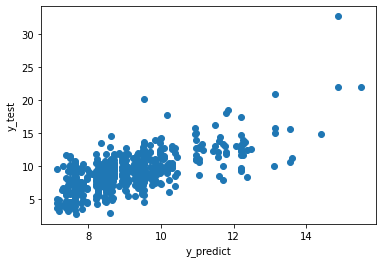

In [15]:
import matplotlib.pyplot as plt # 図の描画用のライブラリ
import seaborn as sns # データ可視化ライブラリ

# Jupyter notebook上に図表を表示する設定
%matplotlib inline

plt.xlabel("y_predict")
plt.ylabel("y_test")
plt.scatter(y_predict, y_test)
plt.savefig("tbs_plot.png",bbox_inches='tight')
plt.show()

In [16]:
# 相関係数を計算
correlation_coefficient = np.corrcoef(y_predict, y_test)[0, 1]
print(correlation_coefficient)

0.674560715083566


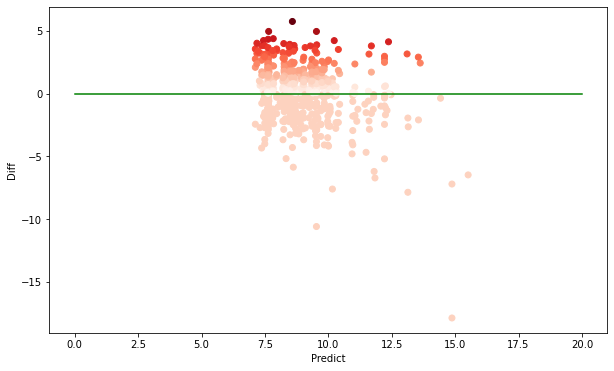

In [17]:
predicts = [[pre , pre - y_t ] for pre , y_t  in zip(y_predict , y_test)]    # 予測値との差を作成，pythonっぽい書き方
data_x = [p[0] for p in predicts]
data_y = [p[1] for p in predicts]

plt.figure(figsize=(10,6))
cm1 = [ 1 if c<0 else c for c in  data_y ]
plt.scatter(data_x , data_y , c=cm1, cmap='Reds')
plt.plot([0, 20], [0, 0],color="green")
plt.xlabel('Predict')
plt.ylabel('Diff')
plt.show()